In [6]:
import sys
import os

parent = os.path.dirname(os.path.realpath('../'))
sys.path.append(parent)

import numpy as np


import scipy
import tqdm
import open3d as o3d
import matplotlib.pyplot as plt
import glob

from core import *
from utils import phantom_builder
from utils import geometry

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [7]:
voxel_size = np.array([0.0005, 0.0005, 0.0005])
surface_mesh = o3d.io.read_triangle_mesh(f"{parent}/assets/kidney_phantom/00_abdomen_cropped.obj")
body_mask = phantom_builder.voxelize(voxel_size[0], mesh=surface_mesh)

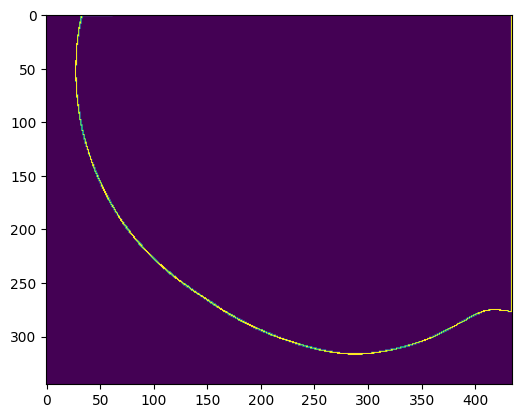

In [3]:
plt.imshow(body_mask[:, :, 200])

In [8]:
test_phantom = phantom.Phantom(source_path = None,
                               voxel_dims = (voxel_size[0], voxel_size[0], voxel_size[0]),
                               matrix_dims = body_mask.shape,
                               baseline = (1540, 1000),
                               seed = 5678,
                               )

blood = tissue.Tissue(name='blood', c=1578, rho=1060, sigma=1.3, scale=0.00001, label=1)
medulla = tissue.Tissue(name='renal_medulla', c=1564, rho=1044, sigma=40, scale=0.0001, label=2)
cortex = tissue.Tissue(name='renal_cortex', c=1571.3, rho=1049, sigma=5, scale=0.0001, label=3)
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=0, scale=1, label=4)
connective = tissue.Tissue(name='connective_tissue', c=1450, rho=1027, sigma=30, scale=0.0001, label=5)
muscle = tissue.Tissue(name='muscle', c=1580, rho=1090, sigma=0, scale=0.0001, label=6)
bone = tissue.Tissue(name='bone', c=2500, rho=1800, sigma=0, scale=0.0001, label=7)
# skin = tissue.Tissue(name='skin', c=1624, rho=1109, sigma=1.3, scale=0.00001, label=8)
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=0, scale=1, label=9)

kidney_file_dir = f"{parent}/assets/kidney_phantom/"
kidney_tissue_list = [fat, muscle, muscle, bone, connective, cortex, blood, blood, medulla]

# test_phantom.add_tissue(fat, mask=np.ones(test_phantom.matrix_dims))
test_phantom.build_organ_from_mesh(surface_mesh, voxel_size[0], kidney_tissue_list, dir_path = kidney_file_dir)
test_phantom.set_default_tissue('water')

Added fat
Added muscle
Added muscle
Added bone
Added connective_tissue
Added renal_cortex
Added blood
Added blood
Added renal_medulla


In [9]:
test_phantom.get_complete().shape

(2, 345, 435, 416)

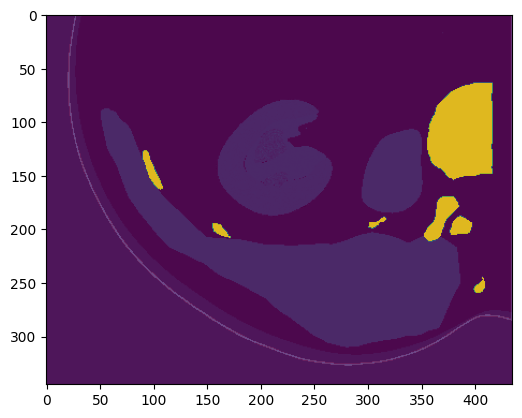

In [7]:
plt.imshow(test_phantom.get_complete()[0, :, :, 200])
plt.imshow(body_mask[:,:, 250] * 1000, alpha=0.2, cmap='Reds_r')

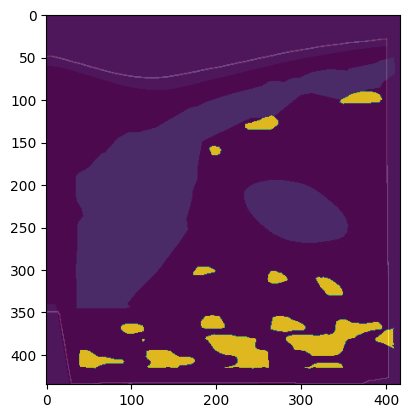

In [8]:
plt.imshow(test_phantom.get_complete()[0, 200, :, :])
plt.imshow(body_mask[180,:, :] * 1000, alpha=0.2, cmap='Reds_r')

In [4]:
num_transducers = 10

transducers = [transducer.Planewave(max_frequency=1e6,
                                    elements = 32, 
                                    width = 40e-3,
                                    height =  20e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = np.pi/3,
                                    ray_num = 32, 
                                    imaging_ndims = 2,
                                    focus_elevation = 20e-3,
                                    ) for i in range(num_transducers)]

for t in transducers:
    t.make_sensor_coords(1540) # test_phantom.baseline[0]

test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)

In [15]:
surface_mesh.get_max_bound()-surface_mesh.get_min_bound()

array([0.051215  , 0.064918  , 0.11148499])

In [44]:
pt, normal = test_transducer_set.place_on_mesh_voxel(0, surface_mesh,[10,20,50], voxel_size[0])
pt = np.array([pt[0], pt[1], pt[2]])
# normal = -np.array([normal[0] - 0.1, normal[1] - 0.5, normal[2] + 0.3])
normal = -np.array([normal[0], normal[1], normal[2]])

pose = geometry.Transform.make_from_heading_vector(normal, pt)

theta = np.pi/2
# theta = 0
for i in range(num_transducers):
    about_nl_axis = geometry.Transform(rotation=tuple(theta*normal), translation=(0, 0, 0), about_axis=True)
    
    transducer_pose = about_nl_axis * pose
    
    test_transducer_set.assign_pose(i, transducer_pose)


In [5]:
pt, normal = test_transducer_set.place_on_mesh_voxel(0, surface_mesh,[240,70,330], voxel_size[0])
pt = np.array([pt[0], pt[1], pt[2]])
normal = -np.array([normal[0] - 0.1, normal[1] - 0.5, normal[2] + 0.3])

pose = geometry.Transform.make_from_heading_vector(normal, pt)

theta = np.pi/2
# theta = 0
for i in range(num_transducers):
    about_nl_axis = geometry.Transform(rotation=tuple(theta*normal), translation=(0, i*0.001,0), about_axis=True)
    
    transducer_pose = about_nl_axis * pose
    
    test_transducer_set.assign_pose(i, transducer_pose)

In [6]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='transmit_as_receive')

In [7]:
sensor_coord = np.mean(test_sensor.sensor_coords, axis=0) / voxel_size + np.array(test_phantom.matrix_dims)/2

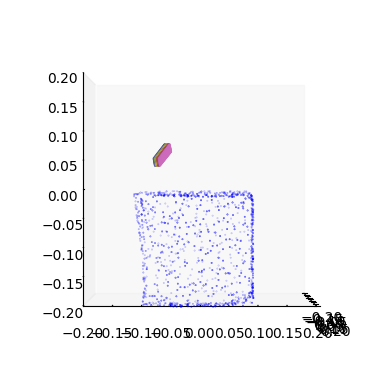

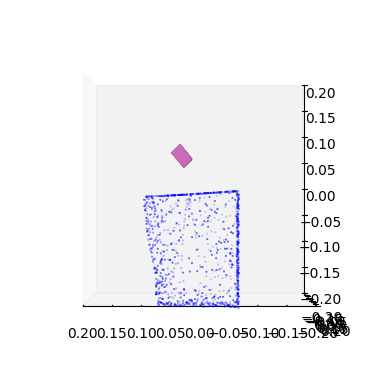

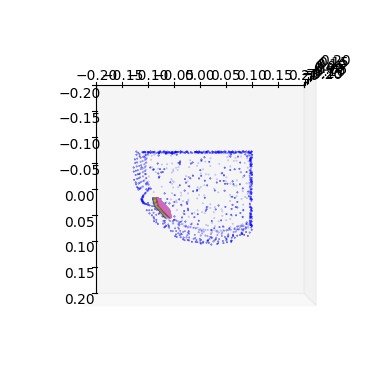

In [9]:
points = np.array((o3d.io.read_triangle_mesh(f"{parent}/assets/kidney_phantom/00_abdomen_cropped.obj")).sample_points_uniformly(1000).points)
points = points[:,[0,1,2]] - np.mean(points, axis=0)

test_transducer_set.plot_transducer_coords(scale = 0.2, phantom_coords = points, view=(0,0))
test_transducer_set.plot_transducer_coords(scale = 0.2, phantom_coords = points, view=(0,90))
test_transducer_set.plot_transducer_coords(scale = 0.2, phantom_coords = points, view=(90,0))

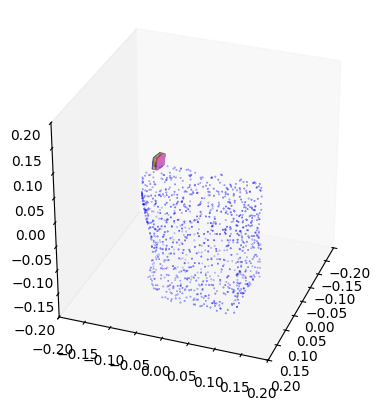

In [13]:
test_transducer_set.plot_transducer_coords(scale = 0.2, phantom_coords = points, view=(30,20))

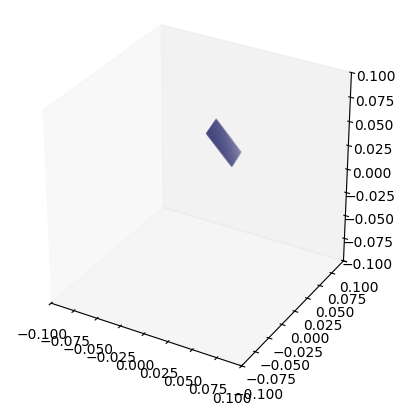

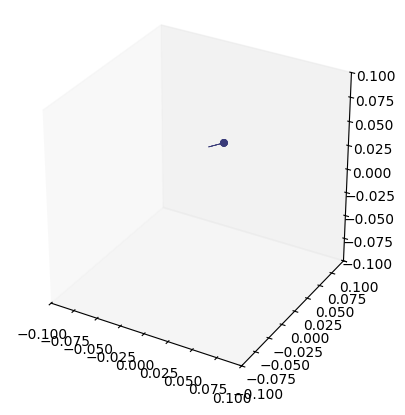

In [10]:
test_transducer_set.plot_transducer_coords()
test_transducer_set.plot_transducer_fovs()

In [8]:
simprops = simulation.SimProperties(
                grid_size   = (150e-3,80e-3,80e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (8,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [9]:
test_experiment = experiment.Experiment(
                 simulation_path = f'{parent}/experiment_files/kidney_experiment_02',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 3,
                 additional_keys = []
                 )

test_experiment.save()

Slurm environment detected. Found 2 cpus available
Setting repeat to -1 to avoid asynchronous index allocation


In [14]:
# test_experiment.plot_ray_path(0)

In [ ]:
# test_experiment.plot_ray_path(31)

In [ ]:
# test_experiment.plot_ray_path(-1)

In [10]:
test_experiment = experiment.Experiment.load(f'{parent}/experiment_files/kidney_experiment_02')
test_experiment.run(dry=True)

Slurm environment detected. Found 2 cpus available
Setting repeat to -1 to avoid asynchronous index allocation
Number of simulation results (320) is greater than the expected number of simulation results (32), did the experiment parameters change since running?
dry run of simulation


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


In [11]:
test_experiment.run(repeat=False)

Found no more simulations to run.


In [12]:
test_experiment.add_results()

In [13]:
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

In [14]:
image_matrices = test_reconstruction.compound(workers=16, resolution_multiplier=4, return_local=True)

 10%|█         | 32/320 [00:00<00:00, 210043.39it/s]


IndexError: list index out of range

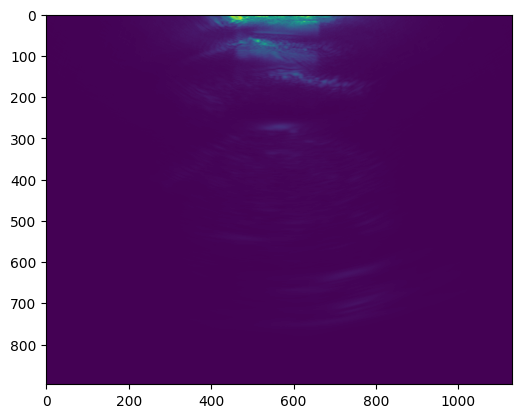

In [23]:
# image = np.sum(image_matrices, axis=0)
# plt.imshow(image[:,:,image.shape[2]//2])
plt.imshow(image_matrices[:,:,0])

In [22]:
image_matrices.shape

(897, 1130, 1)

## View image

In [3]:
import numpy as np

image = np.load("test_image_0.npy")

In [2]:
## test for save
import os
import numpy as np
import matplotlib.pyplot as plt

# Subfolder path
subfolder = "output_files"

# Create the subfolder if it doesn't exist
os.makedirs(subfolder, exist_ok=True)

# Example data to save
for i in range(10):
    # Create some dummy data
    data = np.random.rand(100, 100)  # Replace with your actual data
    
    # Save as .npy file
    npy_filename = os.path.join(subfolder, f"image_{i}.npy")
    np.save(npy_filename, data)
    
    # Save as .png image
    image_filename = os.path.join(subfolder, f"image_{i}.png")
    plt.imsave(image_filename, data, cmap='gray')  # Use appropriate colormap

    print(f"Saved files: {npy_filename}, {image_filename}")

Saved files: output_files/image_0.npy, output_files/image_0.png
Saved files: output_files/image_1.npy, output_files/image_1.png
Saved files: output_files/image_2.npy, output_files/image_2.png
Saved files: output_files/image_3.npy, output_files/image_3.png
Saved files: output_files/image_4.npy, output_files/image_4.png
Saved files: output_files/image_5.npy, output_files/image_5.png
Saved files: output_files/image_6.npy, output_files/image_6.png
Saved files: output_files/image_7.npy, output_files/image_7.png
Saved files: output_files/image_8.npy, output_files/image_8.png
Saved files: output_files/image_9.npy, output_files/image_9.png


In [4]:
image.shape

(225, 283, 1)

In [16]:
import matplotlib.pyplot as plt

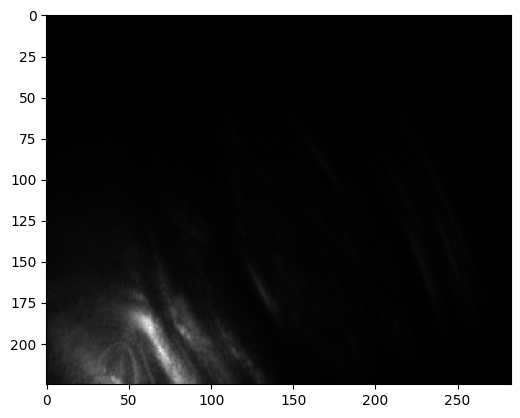

In [5]:
plt.imshow(image[:,:,0], cmap='gray')
plt.show()